# Regression model

## Load libraries
First of all, boring stuff, loading libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '/root/projects/pyphoon/')
from os.path import join
from os import listdir
from os import environ
import numpy as np
import h5py
import gc
import cv2
import pandas as pd

from pyphoon.app.utils import load_h5datachunks
from pyphoon.app.preprocess import MeanImagePreprocessor

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, \
    Flatten, Activation, Reshape, Dropout, add
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras import backend as K
from keras.utils import np_utils
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


We will use GPU with identifier "1", after agreeing with other users with access to the same machine.

In [3]:
environ["CUDA_VISIBLE_DEVICES"]="1"

Time to load the data. We will use the first 10 chunks for test, the next 10 for validation and the remaining for training. Note that loading will take a while.

In [5]:
# Paths where data is stored
dataset_dir = '/root/fs9/lucas/data/datasets/task_2_sequence/'
chunk_filenames = listdir(dataset_dir)
test_chunk_filenames = chunk_filenames[:10]
valid_chunk_filenames = chunk_filenames[10:20]
train_chunk_filenames = chunk_filenames[20:]

In [8]:
X_valid[0].shape

(3267, 256, 256, 1)

In [7]:
X_test, Y_test = load_h5datachunks(dataset_dir, 
                                     test_chunk_filenames, 
                                     features=['data', 'pressure'],
                                     ignore_classes=[6, 7],
                                     display=True
                                     )

X_valid, Y_valid, idx_valid, seqno_valid = load_h5datachunks(dataset_dir,
                                                             valid_chunk_filenames, 
                                                             features=['data', 'pressure', 'idx', 'seq_no'],
                                                             ignore_classes=[6, 7],
                                                             display=True
                                                            )


X_train, Y_train = load_h5datachunks(dataset_dir, 
                                     train_chunk_filenames, 
                                     features=['data', 'pressure'],
                                     ignore_classes=[6, 7],
                                     display=True
                                     )

 file test_0.h5 read
 file test_1.h5 read
 file test_2.h5 read
 file test_3.h5 read
 file test_4.h5 read
 file test_5.h5 read
 file test_6.h5 read
 file test_7.h5 read
 file test_8.h5 read
 file test_9.h5 read
 file train_0.h5 read
 file train_1.h5 read
 file train_2.h5 read
 file train_3.h5 read
 file train_4.h5 read
 file train_5.h5 read
 file train_6.h5 read
 file train_7.h5 read
 file train_8.h5 read
 file train_9.h5 read
 file train_10.h5 read
 file train_11.h5 read
 file train_12.h5 read
 file train_13.h5 read
 file train_14.h5 read
 file train_15.h5 read
 file train_16.h5 read
 file train_17.h5 read
 file train_18.h5 read
 file train_19.h5 read
 file train_20.h5 read
 file train_21.h5 read
 file train_22.h5 read
 file train_23.h5 read
 file train_24.h5 read
 file train_25.h5 read
 file train_26.h5 read
 file train_27.h5 read
 file train_28.h5 read
 file train_29.h5 read
 file train_30.h5 read
 file train_31.h5 read
 file train_32.h5 read
 file train_33.h5 read
 file train_34.h5 

## Data Preprocessing

Note that to preprocess the images (centre and normalise) we require the preprocessing parameters. Hence, these parameters will depend on the dataset being used. Currently, there are two dataset versions:

- **sequence**: The trainig, validation and test datasets have been generated at sequence level. That is, images belonging to the same typhoon sequence find themselves only in one set. These parameters are found under `'../../tasks/multiclass/preprocessing_sequence.h5'`. 
- **random**: The training, validation and test datasets have been generated at image level. That is, totally random, meaning that images from same sequences may be found in different sets. These parameters are found under `'../../tasks/multiclass/preprocessing_random.h5'`.

These files, contain preprocessing parameters to be used in an instance of `MeanImagePreprocessor`, which used the image mean instead of pixel mean. If you rather use pixel-level information you may want to use `DefaultImagePreprocessor` with arguments `mean=1269.15` and `std=24.14` to obtain unitary standard deviation or `std=75` to, somehow, place the values between [-1,1] range.

### Input samples 128 size
We scale down the images so that training is faster and we can easily get an idea of the performance of the model.

In [21]:
# Define preprocessor
with h5py.File('../../tasks/multiclass/preprocessing_sequence.h5') as f:
    mean = f.get('image_mean_128').value
    scale_factor = f.get('max_value_128').value - f.get('min_value_128').value
preprocessor128 = MeanImagePreprocessor(mean, scale_factor, (128,128), 'keras')

In [28]:
# Preprocess
print("train")
n = len(X_train)
X_train128 = [np.expand_dims(preprocessor128.apply(X_train[i][:,:,:,0]), axis=3) for i in range(n)]
print("valid")
n = len(X_valid)
X_valid128 = [np.expand_dims(preprocessor128.apply(X_valid[i][:,:,:,0]), axis=3) for i in range(n)]
print("test")
n = len(X_test)
X_test128 = [np.expand_dims(preprocessor128.apply(X_test[i][:,:,:,0]), axis=3) for i in range(n)]

train
valid
test


### Input samples 256 size
Time to preprocess images preserving original size.

In [25]:
# Define preprocessor
with h5py.File('../../tasks/multiclass/preprocessing_sequence.h5') as f:
    mean = f.get('image_mean_256').value
    scale_factor = f.get('max_value_256').value - f.get('min_value_256').value
preprocessor256 = MeanImagePreprocessor(mean, scale_factor, (256,256), 'keras')

In [35]:
# Preprocess
print("train")
n = len(X_train)
X_train = [np.expand_dims(preprocessor256.apply(X_train[i][:,:,:,0]), axis=3) for i in range(n)]
print("valid")
n = len(X_valid)
X_valid = [np.expand_dims(preprocessor256.apply(X_valid[i][:,:,:,0]), axis=3) for i in range(n)]
print("test")
n = len(X_test)
X_test = [np.expand_dims(preprocessor256.apply(X_test[i][:,:,:,0]), axis=3) for i in range(n)]

train
valid
test


### Normalise output labels (pressure)

In [179]:
# Get mean pressure
pressure_mean = None
n_samples = 0
for y in Y_train:
    if pressure_mean is None:
        pressure_mean = np.sum(y, axis=0)
    else:
        pressure_mean += np.sum(y, axis=0)

    n_samples += len(y)

pressure_mean /= n_samples

In [185]:
# Get max and min pressure values
pressure_min = 2000
pressure_max = -1
n_samples = 0
for y in Y_train:
    _min = np.min(y, axis=0)
    _max = np.max(y, axis=0)
    pressure_min = np.minimum(_min, pressure_min)
    pressure_max = np.maximum(_max, pressure_max)

scale = 1050 - 870 

In [186]:
# Scale output
Y_test = [(Y_test[i]-pressure_mean) / scale for i in range(len(Y_test))]
Y_train = [(Y_train[i]-pressure_mean) / scale for i in range(len(Y_train))]
Y_valid = [(Y_valid[i]-pressure_mean) / scale for i in range(len(Y_valid))]

In [233]:
# Rescale output
Y_test = [Y_test[i] * scale + pressure_mean for i in range(len(Y_test))]
Y_train = [Y_train[i] * scale + pressure_mean for i in range(len(Y_train))]
Y_valid = [Y_valid[i] * scale + pressure_mean for i in range(len(Y_valid))]

## Pressure distribution

Let us explore how the pressure behaves. Importantly is to detect if it has a decent balanced distribution.

In [36]:
h = None
bins = [870, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990, 1000, 1010, 1020]
for y in Y_train:
    if h is None:
        h = np.histogram(y, bins=bins)[0]
    else:
        h += np.histogram(y, bins=bins)[0]

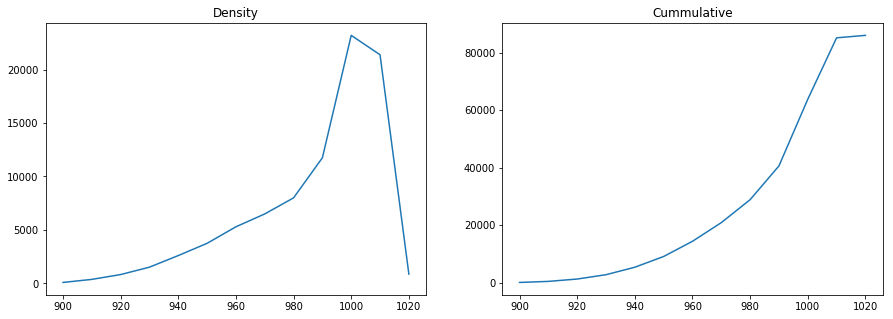

In [38]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title("Density")
plt.plot(bins[1:], h)
plt.subplot(122)
plt.title("Cummulative")
plt.plot(bins[1:], np.cumsum(h))
plt.show()

In [39]:
input_img = Input(shape=(128, 128, 1), name="in")

# Conv layers
x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', name='conv1', kernel_regularizer=l2(0.01), use_bias=False)(
    input_img)
x = Activation('relu', name='act1')(x)
x = BatchNormalization(name="bn1")(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool1')(x)


x = Conv2D(128, (3, 3), strides=(1, 1), padding='same', name='conv2', kernel_regularizer=l2(0.1), use_bias=False)(x)
x = Activation('relu', name='act2')(x)
x = BatchNormalization(name="bn2")(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool2')(x)


x = Conv2D(128, (3, 3), strides=(1, 1), padding='same', name='conv3', kernel_regularizer=l2(0.01), use_bias=False)(x)
x = Activation('relu', name='act3')(x)
x = BatchNormalization(name="bn3")(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool3')(x)


x = Conv2D(256, (3, 3), strides=(1, 1), padding='same', name='conv4', kernel_regularizer=l2(0.01), use_bias=False)(x)
x = Activation('relu', name='act4')(x)
x = BatchNormalization(name="bn4")(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool4')(x)


x = Conv2D(256, (3, 3), strides=(1, 1), padding='same', name='conv5', kernel_regularizer=l2(0.01), use_bias=False)(x)
x = Activation('relu', name='act5')(x)
x = BatchNormalization(name="bn5")(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool5')(x)


# Dense layers
x = Flatten()(x)

x = Dense(1024, use_bias=False, name="fc1")(x)
x = Activation('relu', name="fc_act1")(x)
x = BatchNormalization(name="fc_bn1")(x)
x = Dropout(0.2, name="drop1")(x)

x = Dense(256, use_bias=False, name="fc2")(x)
x = Activation('relu', name="fc_act2")(x)
x = BatchNormalization(name="fc_bn2")(x)

# Out
x = Dense(1, use_bias=True, name="fc_end")(x)
#x = Activation('tanh', name="out")(x)

# Model
model = Model(input_img, x)

In [286]:
# model.load_weights('pressure_seq2/weights-improvement-09-8.02.hdf5')

In [277]:
#W = model.get_weights()
#W[30].shape
#plt.hist(W[36].flatten(), bins=50)
#plt.show()

In [278]:
# model.summary()

In [40]:
def mean_error(y_true, y_pred):
    return K.mean(K.abs(y_true-y_pred))

In [41]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=[mean_error])

## Callbacks

In [42]:
use_callbacks = True
callbacks = []

if use_callbacks:
    # Tensorboard
    use_tensorboard = True
    tensorboard_path = '/tmp/pressure_seq3'
    if use_tensorboard:
        callbacks.append(TensorBoard(log_dir=tensorboard_path, histogram_freq=0,
                                     write_graph=True, write_images=True))

    # Save model
    filepath = "pressure_seq3/weights-improvement-{epoch:02d}-{val_mean_error:.2f}.hdf5"
    m_cp = ModelCheckpoint(filepath, monitor='val_loss', verbose=0,
                           save_best_only=True, save_weights_only=False,
                           mode='auto', period=1)

    callbacks.append(m_cp)

## Data generators

In [43]:
def data_generator_from_chunklist(X, Y, batch_sz):
    """ Generates batches of data from samples **X** and labels **Y**.

    :param X: Sample data.
    :type X: list
    :param Y: Label data.
    :type Y: list
    :param batch_sz: Batch size.
    :type batch_sz: int
    :return:
    """
    n_chunks = len(X)
    indices = list(range(n_chunks))

    chunk_count = 0
    while True:
        # Randomise chunk order once all chunks have been seen
        if chunk_count % n_chunks == 0:
            np.random.shuffle(indices)

        # Get chunk for batch generation
        idx = indices[chunk_count % n_chunks]
        _X = X[idx]
        _Y = Y[idx]
        # Shuffle batch data
        n_samples = len(_Y)
        pos = np.arange(n_samples)
        np.random.shuffle(pos)
        _X = _X[pos]
        _Y = _Y[pos]
        #_Y = np_utils.to_categorical(_Y - 2, num_classes=4)

        # Generate batches
        imax = int(n_samples / batch_sz)
        for i in range(imax):
            # Find list of IDs
            x = _X[i * batch_sz:(i + 1) * batch_sz]
            y = _Y[i * batch_sz:(i + 1) * batch_sz]
            yield x, y
        chunk_count += 1

## Train

## Results

In [289]:
model.evaluate_generator(
    generator=data_generator_from_chunklist(X_valid128, Y_valid, batch_sz=batch_size),
    steps=n_valid // batch_size
)

[136.77795606624628, 7.8688645850202601]

Let us first obtain the pressure estimated values from the validation set.

In [290]:
y_pred = []
for idx in range(len(X_valid128)):
    y_pred.append(model.predict(X_valid128[idx]))
y_pred = np.concatenate(y_pred)[:, 0]
y_true = np.concatenate(Y_valid)

### Histogram comparison

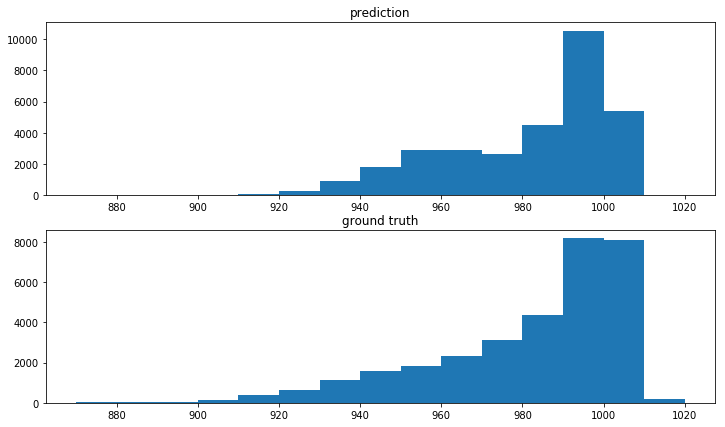

loss: 116.977304332


In [291]:
plt.figure(figsize=(12,7))

plt.subplot(211)
plt.title('prediction')
plt.hist(y_pred, bins=bins)
plt.subplot(212)
plt.title('ground truth')
plt.hist(y_true, bins=bins)
plt.show()

print("loss:", np.mean((y_pred - y_true)**2))

### Ground truth vs Prediction

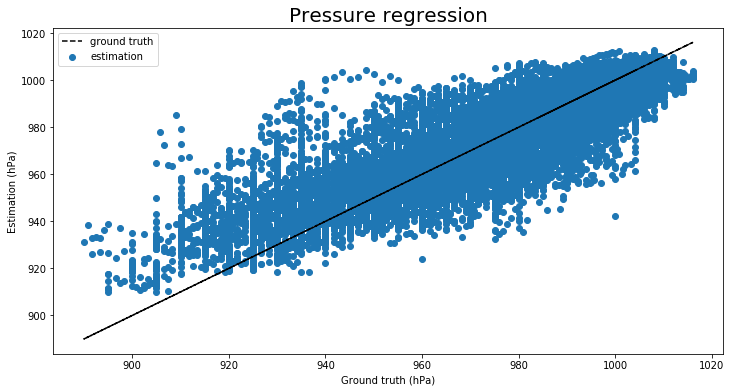

In [292]:
plt.figure(figsize=(12,6))
plt.scatter(y_true, y_pred)
plt.plot(y_true, y_true, 'k--')
plt.title("Pressure regression", fontsize=20)
plt.xlabel("Ground truth (hPa)")
plt.ylabel("Estimation (hPa)")
plt.legend(["ground truth", "estimation"])
plt.show()

### Error curve

In [293]:
error = np.mean(abs(y_true-y_pred))
print("mean error:", error)

mean error: 7.86797045065


In [294]:
# Sort according to ground truth value list
y_true, y_pred = zip(*sorted(zip(y_true, y_pred)))
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Get error per pressure value
pressure_values = np.unique(y_true)
error_per_value = []
for pressure_value in pressure_values:
    pos = y_true <= pressure_value
    error = np.mean(abs(y_pred[pos] - y_true[pos]))
    error_per_value.append(error) 

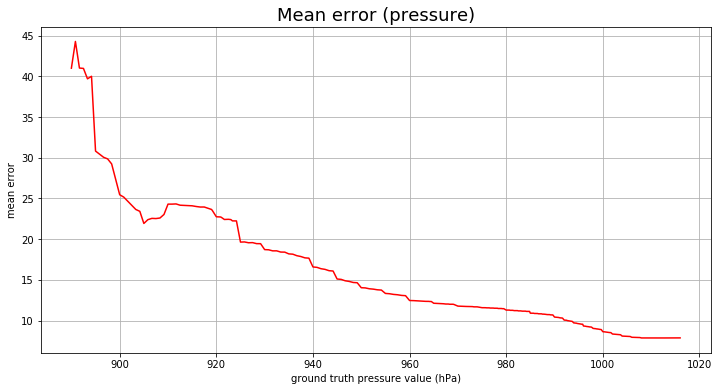

In [295]:
plt.figure(figsize=(12,6))
plt.plot(pressure_values, error_per_value, 'r')
plt.ylabel("mean error")
plt.xlabel("ground truth pressure value (hPa)")
plt.title("Mean error (pressure)", fontsize=18)
plt.grid()
plt.show()

### Activations

In [314]:
import numpy.ma as ma
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [319]:
# Utility functions
# code from: https://github.com/julienr/ipynb_playground/blob/master/keras/convmnist/keras_cnn_mnist.ipynb
def nice_imshow(ax, data, colorbar=False, vmin=None, vmax=None, cmap=None, barsize=None):
    """Wrapper around pl.imshow"""
    #if cmap is None:
    #    cmap = cm.jet
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    divider = make_axes_locatable(ax)
    im = ax.imshow(data, vmin=vmin, vmax=vmax, interpolation='nearest', cmap=cmap)
    if colorbar:
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(im, cax=cax)
        if barsize:
            cbar.ax.tick_params(labelsize=barsize) 
    
def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    nimgs = imgs.shape[0]
    imshape = imgs.shape[1:]
    
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in range(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[i]
    return mosaic


In [344]:
# Function to get activation specific layer
# from: https://github.com/keras-team/keras/issues/41
def get_activations(model, layer, X, preprocess_algorithm=None, dense=False, expand=None):
    if preprocess_algorithm:
        X = preprocess_algorithm(X)
    _get_activations = K.function([model.layers[0].input, K.learning_phase()], [model.layers[layer].output,])
    activations = _get_activations([X, 0])
    if dense:
        if expand:
            return np.vstack([activations[0]]*expand)
        else:
            return activations[0]
    else:
        return np.swapaxes(activations[0], 0, 3)[:, :, :, 0]

In [383]:
def plot_layers(sample):
    layer = 4
    print(model.layers[layer])
    C = get_activations(model, layer, np.expand_dims(sample, axis=0))
    print(len(C))
    plt.figure(figsize=(15, 15))
    plt.title('Feature maps after 1st layer', fontsize=36, y=1.02)
    plt.axis('off')
    nice_imshow(plt.gca(), make_mosaic(C, 8, 8), vmin=-1, vmax=7.5, colorbar=True, barsize=20)
    plt.show()

    layer = 8
    print(model.layers[layer])
    C = get_activations(model, layer, np.expand_dims(sample, axis=0))
    print(len(C))
    plt.figure(figsize=(15, 15))
    plt.title('Feature maps after 2nd layer', fontsize=36, y=1.02)
    plt.axis('off')
    nice_imshow(plt.gca(), make_mosaic(C, 12, 12), vmin=-1, vmax=7.5, colorbar=True, barsize=20)
    plt.show()

    layer = 12
    print(model.layers[layer])
    C = get_activations(model, layer, np.expand_dims(sample, axis=0))
    print(len(C))
    plt.figure(figsize=(15, 15))
    plt.title('Feature maps after L23rd layer', fontsize=36, y=1.02)
    plt.axis('off')
    nice_imshow(plt.gca(), make_mosaic(C, 12, 12), vmin=-1, vmax=7.5, colorbar=True, barsize=20)
    plt.show()

    layer = 16
    print(model.layers[layer])
    C = get_activations(model, layer, np.expand_dims(sample, axis=0))
    print(len(C))
    plt.figure(figsize=(15, 15))
    plt.title('Feature maps after 4th layer', fontsize=36, y=1.02)
    plt.axis('off')
    nice_imshow(plt.gca(), make_mosaic(C, 16, 16), vmin=-1, vmax=7.5, colorbar=True, barsize=20)
    plt.show()

    layer = 20
    print(model.layers[layer])
    C = get_activations(model, layer, np.expand_dims(sample, axis=0))
    print(len(C))
    plt.figure(figsize=(15, 15))
    plt.title('Feature maps after 5th layer', fontsize=36, y=1.02)
    plt.axis('off')
    nice_imshow(plt.gca(), make_mosaic(C, 16, 16), vmin=-1, vmax=7.5, colorbar=True, barsize=20)
    plt.show()

    layer = 25
    print(model.layers[layer])
    C = get_activations(model, layer, np.expand_dims(sample, axis=0), dense=True, expand=100)
    im = plt.imshow(C.T)
    plt.axis('off')
    plt.colorbar(im)
    plt.title('Activations after 1st dense layer', fontsize=10, y=1.02)
    plt.show()

    layer = 28
    print(model.layers[layer])
    C = get_activations(model, layer, np.expand_dims(sample, axis=0), dense=True, expand=100)
    im = plt.imshow(C.T)
    plt.axis('off')
    plt.colorbar(im)
    plt.title('Activations after last layer', fontsize=10, y=1.02)
    plt.show()

pressure 935.0


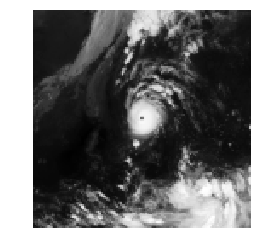

64


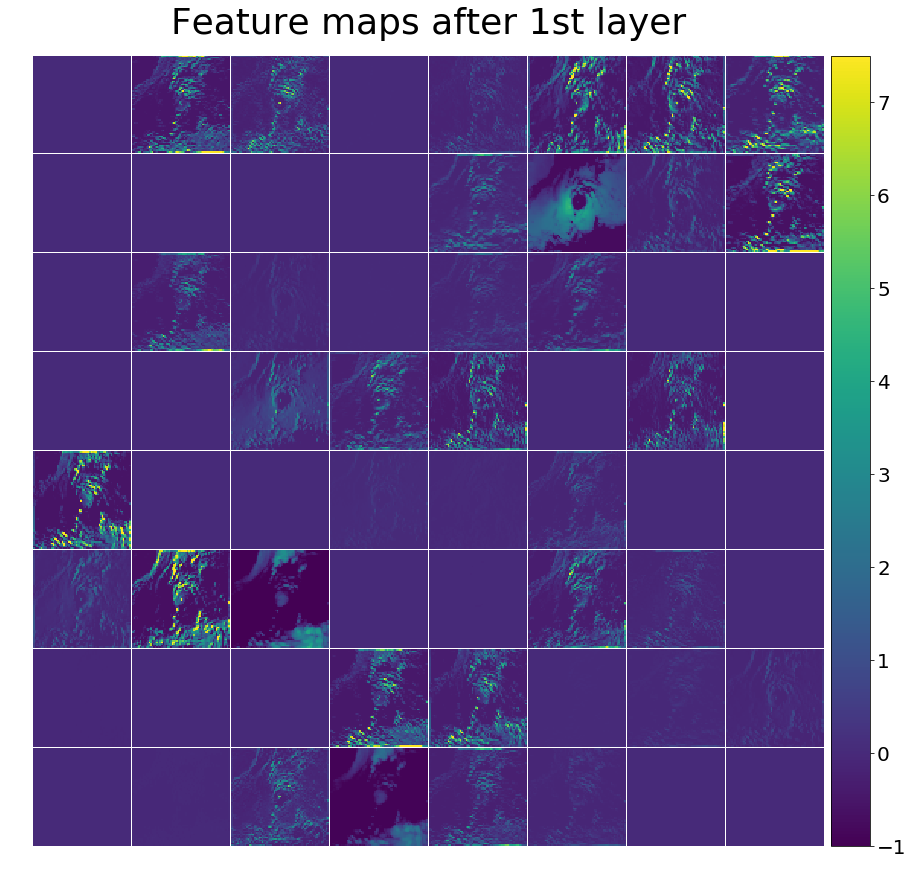

128


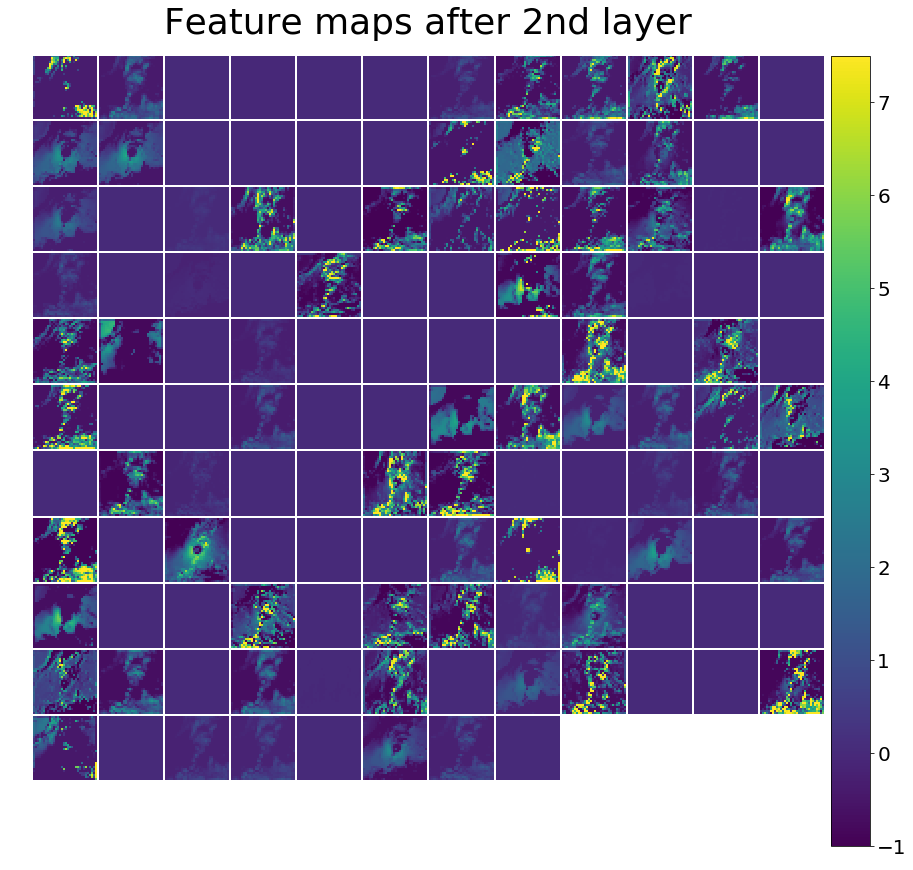

128


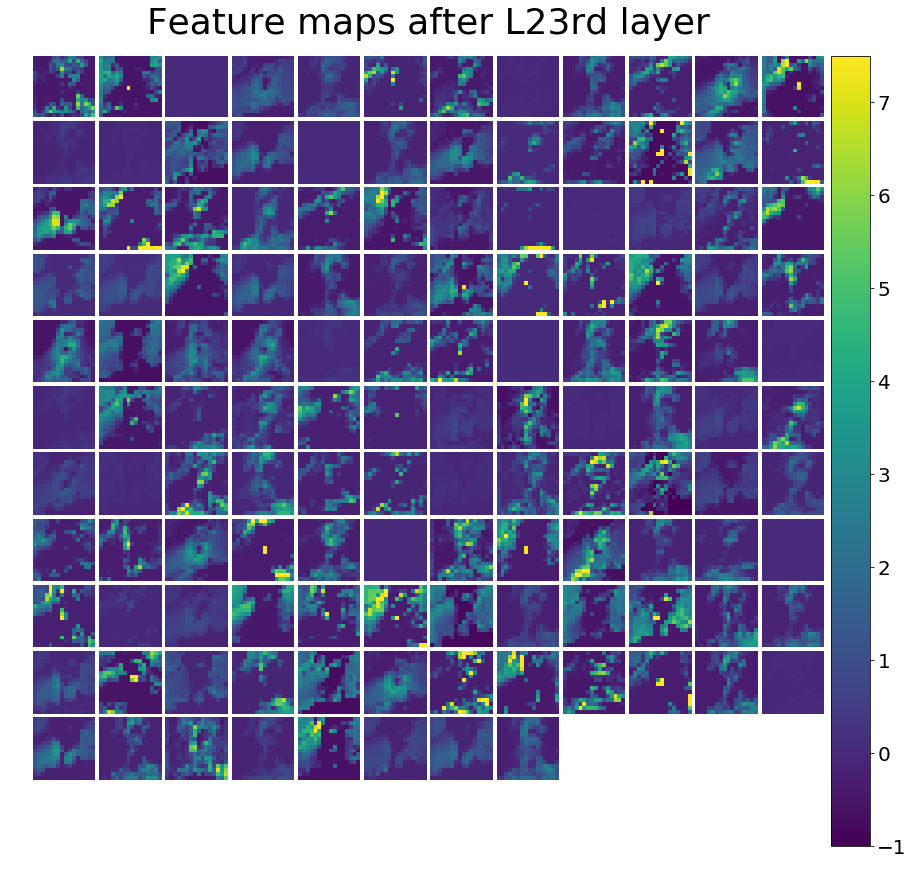

256


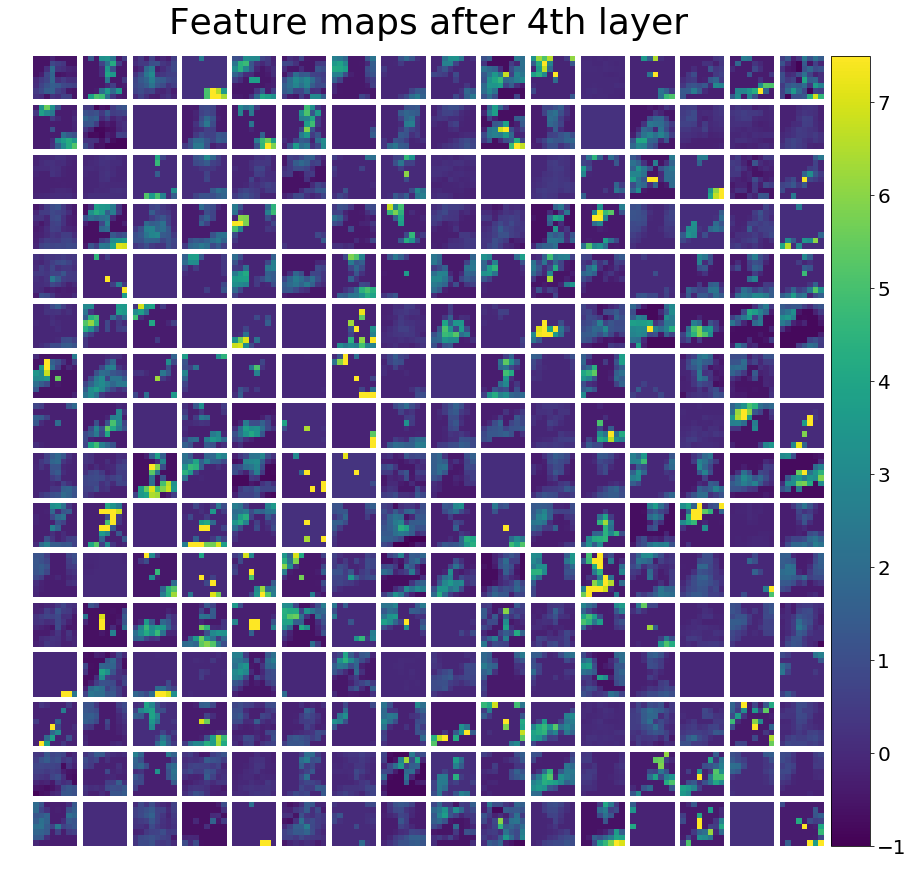

256


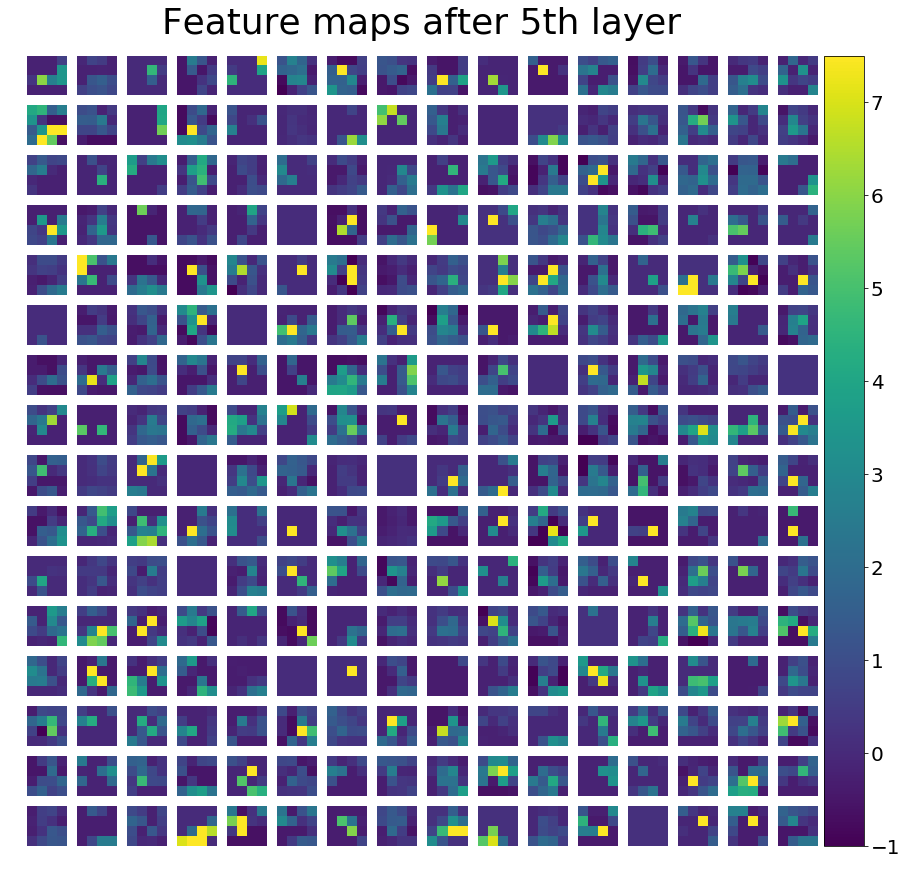

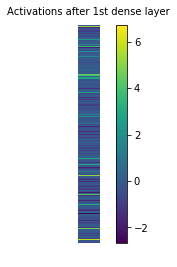

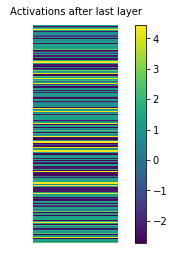

In [384]:
chunk = 6
idx = 2000
sample = X_valid128[chunk][idx]
print("pressure", Y_valid[chunk][idx])
plt.imshow(sample[:,:,0]*scale_factor + mean_128, cmap="Greys")
plt.axis('off')
plt.show()
plot_layers(sample)

pressure 996.0


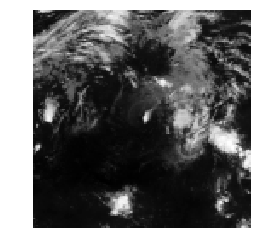

64


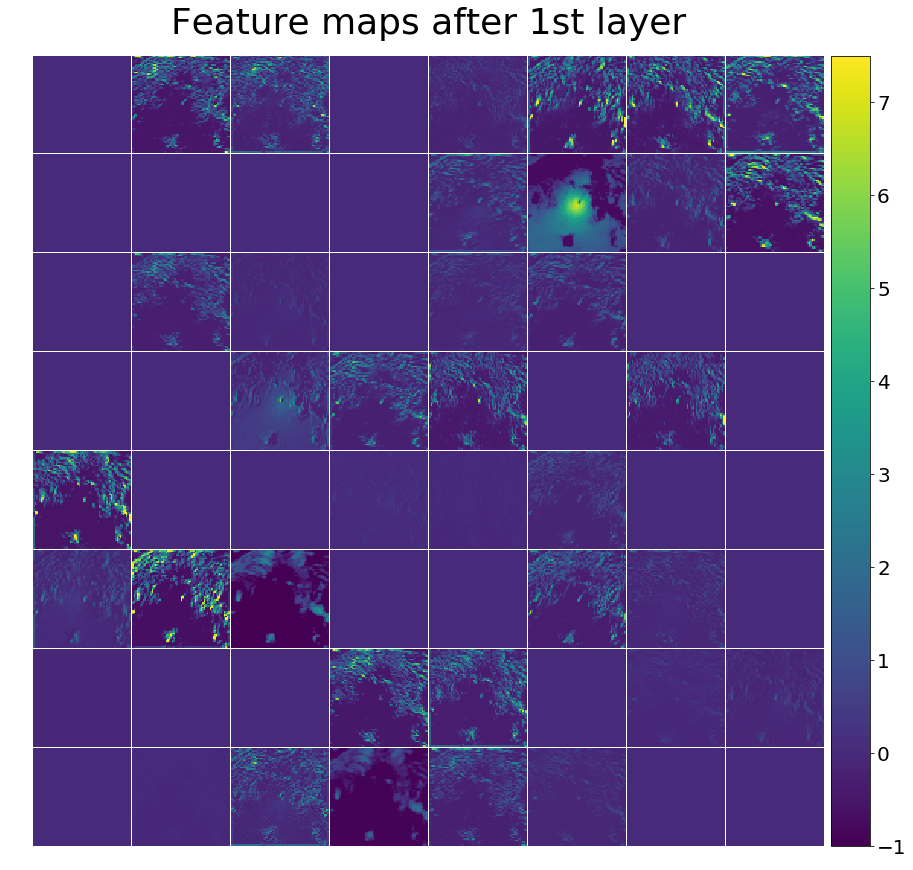

128


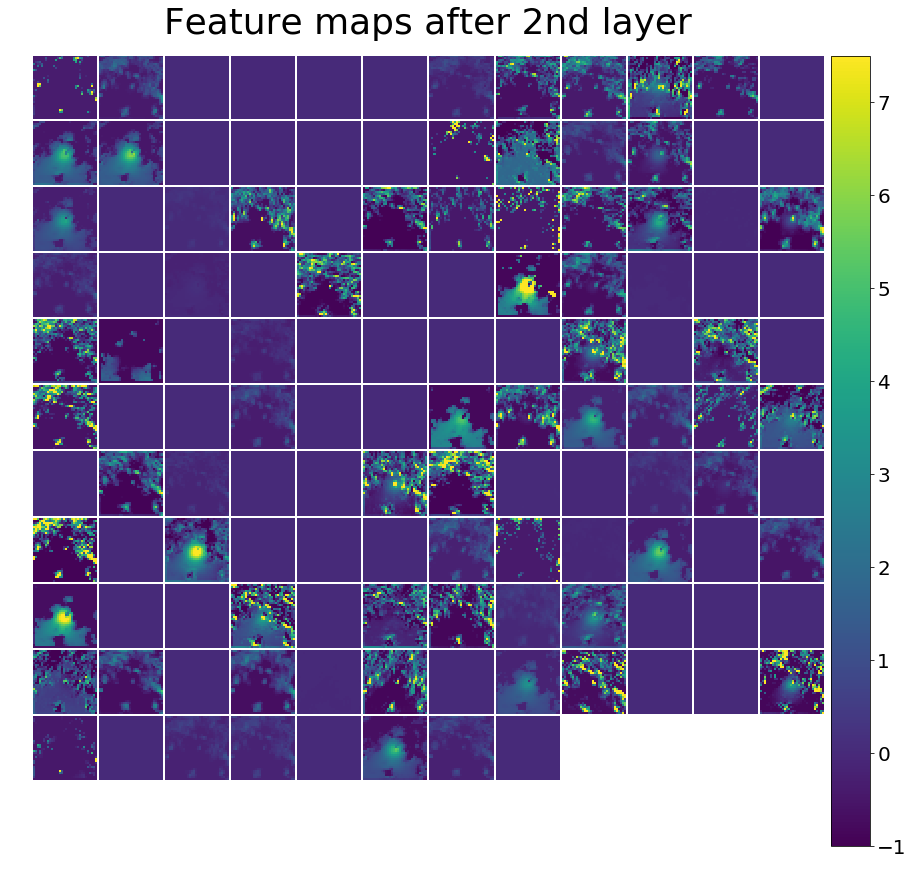

128


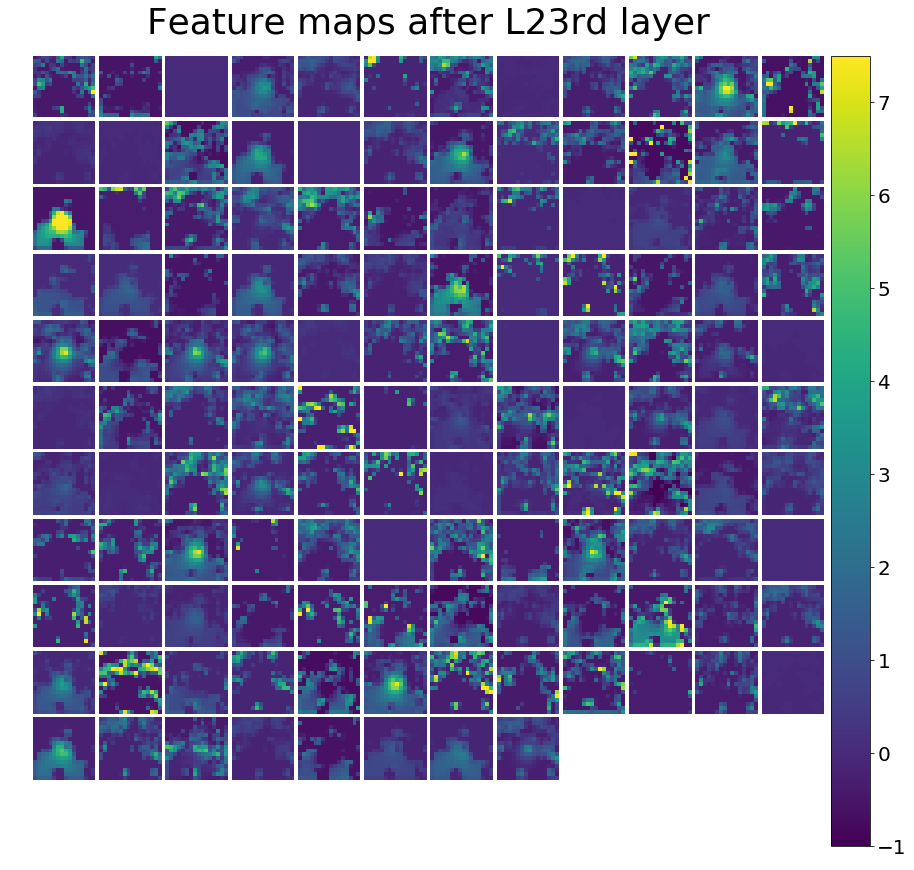

256


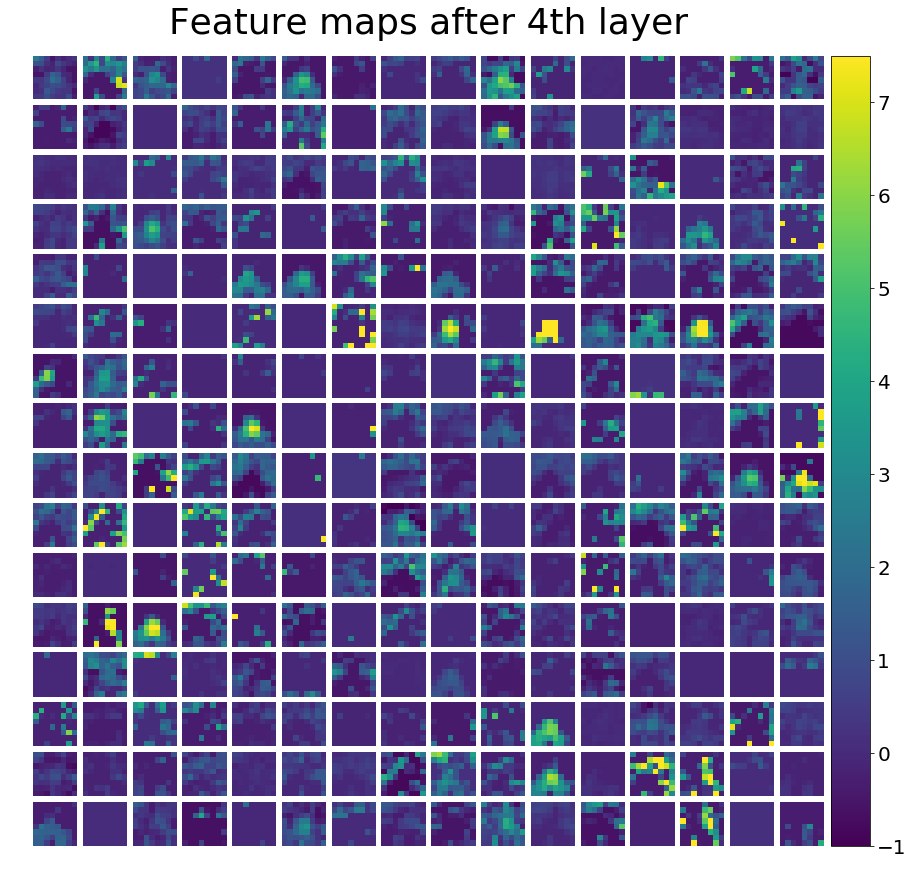

256


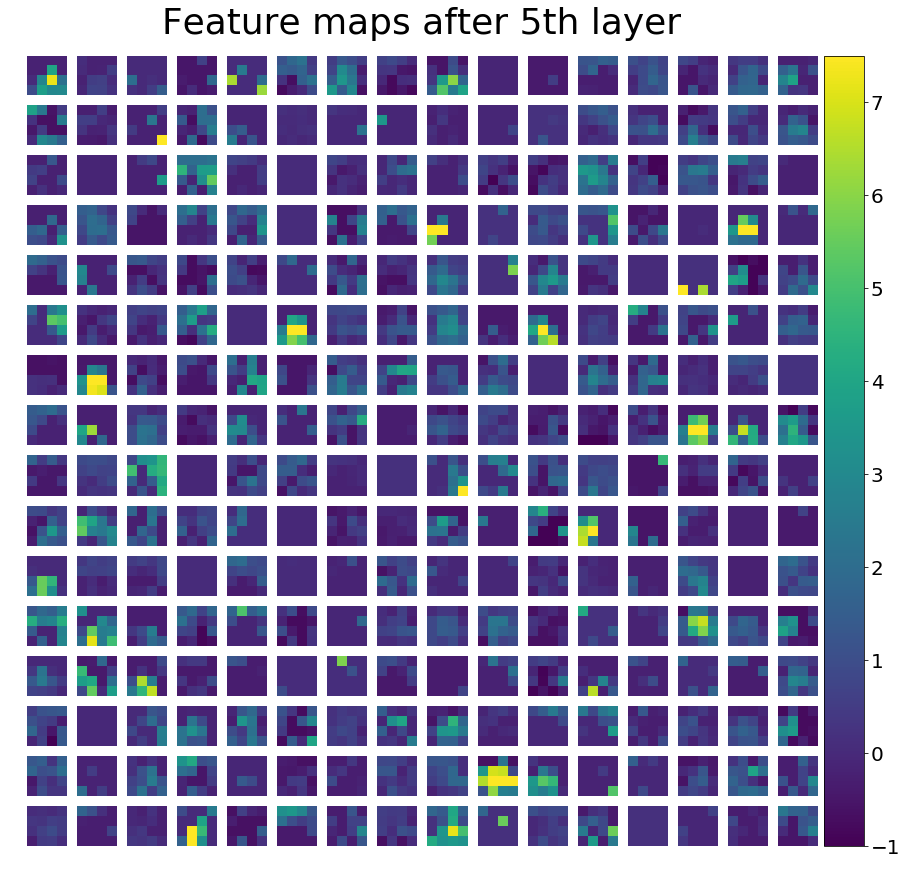

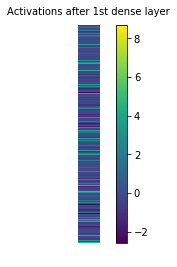

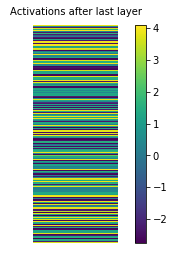

In [385]:
chunk = 2
idx = 2000
sample = X_valid128[chunk][idx]
print("pressure", Y_valid[chunk][idx])
plt.imshow(sample[:,:,0] *scale_factor + mean_128, cmap="Greys")
plt.axis('off')
plt.show()
plot_layers(sample)